# Sparkify Modeling Workspace
For reasons of clarity the Sparkify project has been split into two notebooks, this is part 2.  
Data exploration and development of features is taken care of in part 1, the Sparkify_Data.ipynb notebook.  
The features engineered there are written to a Parquet file mini_sparkify_feature_data.parquet which is loaded again in this notebook for model training to predict customer churn.

### Content:
+ [Modeling](#Modeling)
+ [Pipelines, Grid Search and Cross Validation](#Pipelines,-Grid-Search-and-Cross-Validation)
+ [Model comparison and Conclusion](#Model-comparison-and-Conclusion)

# Modeling
To achieve the goal of predicting customers who churn based on their behaviour and usage pattern, several algorithms are trained and evaluated.  
For this the preprocessed feature data is loaded and used, splitting it randomly in 80% training and 20% testing dataset.

For every model a pipeline is created, containing a VectorAssembler, a StandardScaler and the model itself.  
The VectorAssembler transforms the different feature columns of the dataset into a DenseVector or a SparseVector, while the StandarScaler scales all features to mean zero and standard deviation.

To find the best possible set of parameters for each type of classifier the pipeline is used with ParamGridBuilder and CrossValidator to seach for an optimal parameterset and perform 3-fold cross-validation.

The following models are evaluated:
+ [Logistic Regression](#Logistic-Regression)
+ [Decision Tree Classifier](#Decision-Tree-Classifier)
+ [Gradient Boosted Tree Classifier](#Gradient-Boosted-Tree-Classifier)
+ [Random Forest Classifier](#Random-Forest-Classifier)
+ [Linear Support Vector Classifier](#Linear-Support-Vector-Classifier)
+ [Naive Bayes](#Naive-Bayes)
+ [Multilayer Perceptron Classifier](#Multilayer-Perceptron-Classifier)

Evaluation will be done using *Precision*, *Recall*, *Accuracy* and *F1-Score*. Since the dataset is not balanced well, accuracy isn't the best metric, which is why F1-Score will be preferred to select the best performing algorithm.

#### Imports and functions

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display as d

# PySpark 
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
# PySpark ML
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LinearSVC, NaiveBayes 
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

In [2]:
def evaluate_prediction(data, df=pd.DataFrame(), returndf=True):
    """
    Evaluate predictions vs. labels with precision, recall, accuracy and F1-Score
    INPUTS:
    data: PySpark dataframe containing a column 'label' and 'prediction'
    df: dataframe to append metric information on
    returndf: whether to return the information df or not
    """
    tp = data.filter((data.label == 1) & (data.prediction == 1)).count()
    fp = data.filter((data.label == 0) & (data.prediction == 1)).count()
    tn = data.filter((data.label == 0) & (data.prediction == 0)).count()
    fn = data.filter((data.label == 1) & (data.prediction == 0)).count()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = 2 * precision * recall / (precision + recall)
    print("\n Metrics:")
    print(" - Precision:", np.round(precision, 2))
    print(" - Recall:   ", np.round(recall, 2))
    print(" - Accuracy: ", np.round(accuracy, 2))
    print(" - F1-Score: ", np.round(f1, 2))
    confusion_array = np.array([[tp, fn],
                                [fp, tn]])
    fig, ax = plt.subplots(figsize=(2.2, 2.2))
    im = ax.imshow(confusion_array, cmap="Blues")
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(["Pos", "Neg"])
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.set_yticklabels(["Pos", "Neg"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for i in range(2):
        for j in range(2):
            if confusion_array[i, j] > (0.6 * np.max(confusion_array)):
                color = "w"
            else:
                color = "k"
            text = ax.text(j, i, confusion_array[i, j], ha="center", va="center", color=color)
    fig.tight_layout()
    plt.show();
    
    if returndf:
        return pd.DataFrame({df.columns[0]: [np.round(precision, 2), np.round(recall, 2), 
                                             np.round(accuracy, 2), np.round(f1, 2)]}, 
                            index=["Precision", "Recall", "Accuracy", "F1-Score"]).append(df)
    
    
def plot_feat_importance(model):
    """Create a barplot for feature importance of a models"""
    try:
        feat_importance = pd.DataFrame({"feature": feature_cols, 
                                        "importance": model.bestModel.stages[-1].featureImportances.toArray()}) \
                                        .sort_values("importance", ascending=False)
        feat_importance = feat_importance[feat_importance.importance > 0]
    except:
        pass
    try:
        feat_importance = pd.DataFrame({"feature": feature_cols, 
                                        "importance": model.bestModel.stages[-1].coefficients.toArray()}) \
                                        .sort_values("importance", ascending=False)
    except:
        pass
        
    plt.figure(figsize=(10, 5/27 * len(feat_importance.importance) + 0.15))
    plt.barh(range(len(feat_importance.importance), 0, -1), 
             feat_importance.importance, 
             tick_label=feat_importance.feature);
    plt.title("Feature importance");
    
    
def bestmodel_params(model, prnt=True):
    """
    Print parameters of the best model from CrossValidator
    INPUTS:
    model: model to get best parameters of
    prnt: boolean for print yes/no
    """
    keys = list(model.getEstimatorParamMaps()[np.argmax(model.avgMetrics)].keys())
    values = list(model.getEstimatorParamMaps()[np.argmax(model.avgMetrics)].values())
    
    params_print = ""
    params = ""
    for key, value in zip(keys, values):
        params_print += f" - {key.name}: {value}\n"
        params += f"{key.name}: {value}, "
    if prnt:
        print("Best model:\n", keys[0].parent.split("_")[0])
        print(params_print.strip("\n"))

    return pd.DataFrame({keys[0].parent.split("_")[0]: 
                         [str(param) + ": "+ str(value) for param, value in zip([key.name for key in keys], values)]}, 
                         index=["opt_param" + str(i) for i in range(len(values))])

#### Create a Spark session

In [3]:
# create the Spark session
spark = SparkSession \
            .builder \
            .appName("sparkify") \
            .getOrCreate()

# show Spark config details
d(spark)
d(spark.sparkContext.getConf().getAll())

[('spark.driver.port', '42203'),
 ('spark.app.name', 'sparkify'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '6760b8203f04'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1625390510213'),
 ('spark.ui.showConsoleProgress', 'true')]

#### Load data

In [4]:
# load feature dataset
file_location = "mini_sparkify_feature_data.parquet"
feature_sdf = spark.read.parquet(file_location).withColumnRenamed("churn_flag", "label")
feature_sdf.persist()
feature_sdf.printSchema()

root
 |-- label: integer (nullable = true)
 |-- membership_duration: integer (nullable = true)
 |-- days_active: long (nullable = true)
 |-- active_rate: double (nullable = true)
 |-- paid_use_share: double (nullable = true)
 |-- paid_sub_share: double (nullable = true)
 |-- page_About: long (nullable = true)
 |-- page_AddFriend: long (nullable = true)
 |-- page_AddtoPlaylist: long (nullable = true)
 |-- page_Downgrade: long (nullable = true)
 |-- page_Error: long (nullable = true)
 |-- page_Help: long (nullable = true)
 |-- page_Home: long (nullable = true)
 |-- page_NextSong: long (nullable = true)
 |-- page_RollAdvert: long (nullable = true)
 |-- page_SubmitDowngrade: long (nullable = true)
 |-- page_SubmitUpgrade: long (nullable = true)
 |-- page_ThumbsDown: long (nullable = true)
 |-- page_ThumbsUp: long (nullable = true)
 |-- page_Upgrade: long (nullable = true)
 |-- device_MacOS: long (nullable = true)
 |-- device_Ubuntu: long (nullable = true)
 |-- device_Windows: long (nullabl

In [5]:
# list of feature columns without churn_flag
feature_cols = feature_sdf.columns
feature_cols.remove("label")

# prepare data transformers to create a feature vector and standardize the data
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
standardscaler = StandardScaler(inputCol="features_vec", outputCol="features", withStd=True)

### Test a standard Logistic Regression


 Metrics:
 - Precision: 0.5
 - Recall:    0.44
 - Accuracy:  0.72
 - F1-Score:  0.47


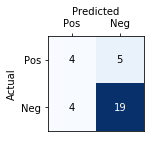

In [6]:
# transform features
feature_vec = assembler.transform(feature_sdf)
feature_vec = standardscaler.fit(feature_vec).transform(feature_vec)
feature_vec = feature_vec.select("label", "features")

# train/test split
train, test = feature_vec.randomSplit([0.8, 0.2], seed=42)
# train the model
logisticregression = LogisticRegression()
model_lr = logisticregression.fit(train)
pred_lr = model_lr.transform(test)
evaluate_prediction(pred_lr, returndf=False)

## Pipelines, Grid Search and Cross Validation

In [7]:
# dataframe to collect information on best models
best_models = pd.DataFrame()

In [8]:
# create a training and testing dataset
train, test = feature_sdf.randomSplit([0.8, 0.2], seed=42)

### Logistic Regression

Best model:
 LogisticRegression
 - maxIter: 10
 - regParam: 0.0
 - elasticNetParam: 0.0
 - fitIntercept: True

 Metrics:
 - Precision: 0.71
 - Recall:    0.56
 - Accuracy:  0.81
 - F1-Score:  0.63


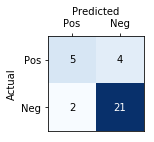

In [9]:
# creating a pipeline
logisticregression = LogisticRegression()
pipeline_lr = Pipeline(stages=[assembler, standardscaler, logisticregression])

# k-fold Cross-Validation for Logistic Regression
params_lr = ParamGridBuilder() \
            .addGrid(logisticregression.maxIter, [5, 10, 20]) \
            .addGrid(logisticregression.regParam, [0, 0.01, 0.1]) \
            .addGrid(logisticregression.elasticNetParam, [0, 0.5, 1]) \
            .addGrid(logisticregression.fitIntercept, [True, False]) \
            .build()

crossvalidation_lr = CrossValidator(estimator=pipeline_lr,
                                 estimatorParamMaps=params_lr,
                                 evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                                 numFolds=3,
                                 seed=42)

cv_model_lr = crossvalidation_lr.fit(train)
cv_pred_lr = cv_model_lr.transform(test)
# evaluate prediction and get best model information
best_lr = evaluate_prediction(cv_pred_lr, bestmodel_params(cv_model_lr, True))
best_models[best_lr.columns] = best_lr

> The parameter optimization with ParamGridBuilder and CrossValidator paid of.  
Accuracy and F1-Score of the Logistic Regression Classifier could be improved from 0.72 / 0.47 to 0.81 / 0.63, compared with the model trained with standard parameters.

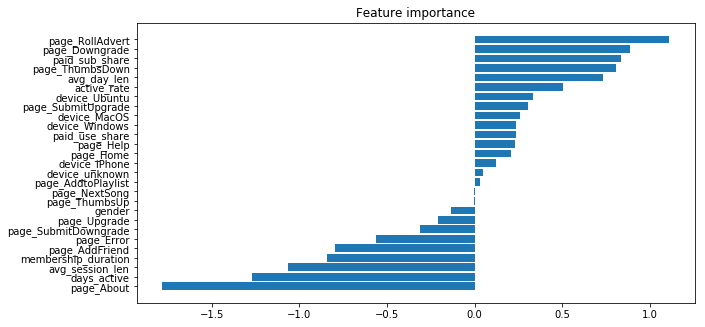

In [10]:
plot_feat_importance(cv_model_lr)

### Decision Tree Classifier

Best model:
 DecisionTreeClassifier
 - maxBins: 32
 - impurity: gini
 - maxDepth: 1

 Metrics:
 - Precision: 0.58
 - Recall:    0.78
 - Accuracy:  0.78
 - F1-Score:  0.67


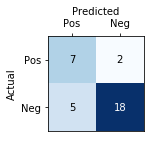

In [11]:
# creating a pipeline
decisiontree = DecisionTreeClassifier(seed=42)
pipeline_dt = Pipeline(stages=[assembler, standardscaler, decisiontree])

# k-fold Cross-Validation with pipeline for Decision Tree Classifier
params_dt = ParamGridBuilder() \
            .addGrid(decisiontree.maxBins , [16, 32, 64]) \
            .addGrid(decisiontree.impurity , ["entropy", "gini"]) \
            .addGrid(decisiontree.maxDepth, [1, 2, 5]) \
            .build()

crossvalidation_dt = CrossValidator(estimator=pipeline_dt,
                                 estimatorParamMaps=params_dt,
                                 evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                                 numFolds=3,
                                 seed=42)

cv_model_dt = crossvalidation_dt.fit(train)
cv_pred_dt = cv_model_dt.transform(test)
# evaluate prediction and get best model information
best_dt = evaluate_prediction(cv_pred_dt, bestmodel_params(cv_model_dt, True))
best_models[best_dt.columns] = best_dt

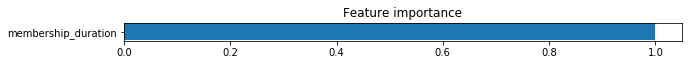

In [12]:
plot_feat_importance(cv_model_dt)

> Interestingly the fairly simple DecisionTreeClassifier chose a very low Depth of 1, resulting in using only one feature for prediction, the membership duration.

### Gradient Boosted Tree Classifier

Best model:
 GBTClassifier
 - maxBins: 64
 - maxIter: 10
 - maxDepth: 2

 Metrics:
 - Precision: 0.67
 - Recall:    0.44
 - Accuracy:  0.78
 - F1-Score:  0.53


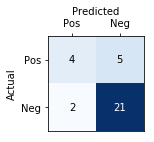

In [13]:
# creating a pipeline
gradienttrees = GBTClassifier(seed=42)
pipeline_gbt = Pipeline(stages=[assembler, standardscaler, gradienttrees])

# k-fold Cross-Validation with pipeline for Gradient Boosted Tree Classifier
params_gbt = ParamGridBuilder() \
            .addGrid(gradienttrees.maxBins , [32, 64, 96]) \
            .addGrid(gradienttrees.maxIter , [5, 10, 20]) \
            .addGrid(gradienttrees.maxDepth, [1, 2, 5]) \
            .build()

crossvalidation_gbt = CrossValidator(estimator=pipeline_gbt,
                                 estimatorParamMaps=params_gbt,
                                 evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                                 numFolds=3,
                                 seed=42)

cv_model_gbt = crossvalidation_gbt.fit(train)
cv_pred_gbt = cv_model_gbt.transform(test)
# evaluate prediction and get best model information
best_gbt = evaluate_prediction(cv_pred_gbt, bestmodel_params(cv_model_gbt, True))
best_models[best_gbt.columns] = best_gbt

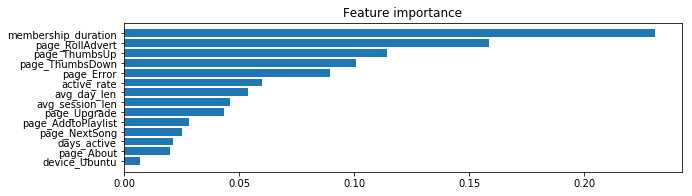

In [14]:
plot_feat_importance(cv_model_gbt)

### Random Forest Classifier

Best model:
 RandomForestClassifier
 - numTrees: 80
 - maxBins: 16
 - impurity: gini
 - maxDepth: 10

 Metrics:
 - Precision: 0.67
 - Recall:    0.44
 - Accuracy:  0.78
 - F1-Score:  0.53


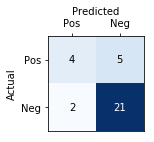

In [15]:
# creating a pipeline
randomforest = RandomForestClassifier(seed=42)
pipeline_rf = Pipeline(stages=[assembler, standardscaler, randomforest])

# k-fold Cross-Validation with pipeline for Random Forest Classifier
params_rf = ParamGridBuilder() \
            .addGrid(randomforest.numTrees, [20, 80, 160]) \
            .addGrid(randomforest.maxBins , [8, 16, 32]) \
            .addGrid(randomforest.impurity , ["entropy", "gini"]) \
            .addGrid(randomforest.maxDepth, [5, 10, 20]) \
            .build()

crossvalidation_rf = CrossValidator(estimator=pipeline_rf,
                                 estimatorParamMaps=params_rf,
                                 evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                                 numFolds=3,
                                 seed=42)

cv_model_rf = crossvalidation_rf.fit(train)
cv_pred_rf = cv_model_rf.transform(test)
# evaluate prediction and get best model information
best_rf = evaluate_prediction(cv_pred_rf, bestmodel_params(cv_model_rf, True))
best_models[best_rf.columns] = best_rf

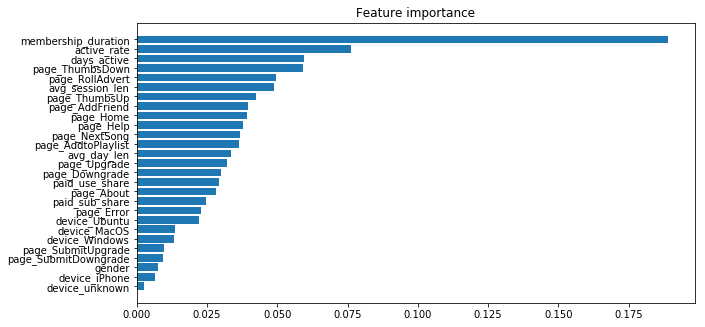

In [16]:
plot_feat_importance(cv_model_rf)

### Linear Support Vector Classifier

Best model:
 LinearSVC
 - maxIter: 100
 - regParam: 0.0
 - fitIntercept: True

 Metrics:
 - Precision: 0.83
 - Recall:    0.56
 - Accuracy:  0.84
 - F1-Score:  0.67


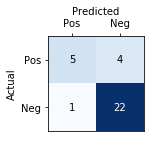

In [17]:
# creating a pipeline
svc = LinearSVC()
pipeline_svc = Pipeline(stages=[assembler, standardscaler, svc])

# k-fold Cross-Validation with pipeline for Linear Support Vector Classifier
params_svc = ParamGridBuilder() \
            .addGrid(svc.maxIter, [50, 100, 150]) \
            .addGrid(svc.regParam, [0, 0.05, 0.2]) \
            .addGrid(svc.fitIntercept, [True, False]) \
            .build()

crossvalidation_svc = CrossValidator(estimator=pipeline_svc,
                                 estimatorParamMaps=params_svc,
                                 evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                                 numFolds=3,
                                 seed=42)

cv_model_svc = crossvalidation_svc.fit(train)
cv_pred_svc = cv_model_svc.transform(test)
# evaluate prediction and get best model information
best_svc = evaluate_prediction(cv_pred_svc, bestmodel_params(cv_model_svc, True))
best_models[best_svc.columns] = best_svc

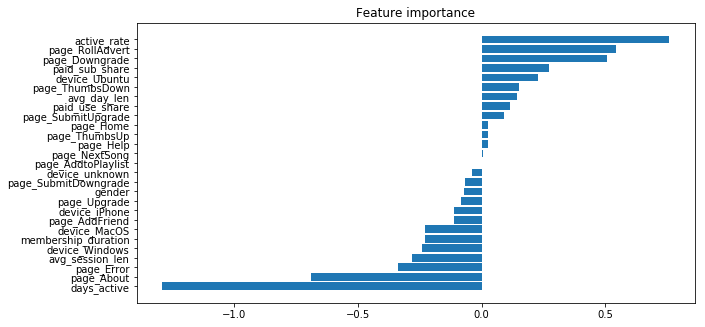

In [18]:
plot_feat_importance(cv_model_svc)

### Naive Bayes

Best model:
 NaiveBayes
 - smoothing: 10.0

 Metrics:
 - Precision: 0.5
 - Recall:    0.11
 - Accuracy:  0.72
 - F1-Score:  0.18


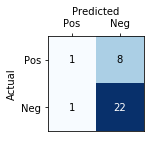

In [19]:
# creating a pipeline
naivebayes = NaiveBayes()
pipeline_nb = Pipeline(stages=[assembler, standardscaler, naivebayes])

# k-fold Cross-Validation with pipeline for Naive Bayes Classifier
params_nb = ParamGridBuilder() \
            .addGrid(naivebayes.smoothing, [0.5, 1, 5, 10, 20]) \
            .build()

crossvalidation_nb = CrossValidator(estimator=pipeline_nb,
                                 estimatorParamMaps=params_nb,
                                 evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                                 numFolds=3,
                                 seed=42)

cv_model_nb = crossvalidation_nb.fit(train)
cv_pred_nb = cv_model_nb.transform(test)
# evaluate prediction and get best model information
best_nb = evaluate_prediction(cv_pred_nb, bestmodel_params(cv_model_nb, True))
best_models[best_nb.columns] = best_nb

### Multilayer Perceptron Classifier

Best model:
 MultilayerPerceptronClassifier
 - maxIter: 20
 - layers: [27, 10, 2]
 - solver: l-bfgs
 - stepSize: 0.005

 Metrics:
 - Precision: 0.64
 - Recall:    0.78
 - Accuracy:  0.81
 - F1-Score:  0.7


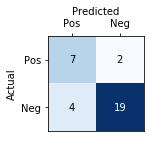

In [20]:
# creating a pipeline
perceptron = MultilayerPerceptronClassifier(seed=42)
pipeline_mlp = Pipeline(stages=[assembler, standardscaler, perceptron])

# k-fold Cross-Validation with pipeline for Multilayer Perceptron Classifier
params_mlp = ParamGridBuilder() \
            .addGrid(perceptron.maxIter, [10, 20, 50, 100]) \
            .addGrid(perceptron.layers, [[27, 5, 2], [27, 10, 2], [27, 25, 2]]) \
            .addGrid(perceptron.solver, ["l-bfgs", "gd"]) \
            .addGrid(perceptron.stepSize, [0.005, 0.01, 0.03]) \
            .build()

crossvalidation_mlp = CrossValidator(estimator=pipeline_mlp,
                                 estimatorParamMaps=params_mlp,
                                 evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                                 numFolds=3,
                                 seed=42)

cv_model_mlp = crossvalidation_mlp.fit(train)
cv_pred_mlp = cv_model_mlp.transform(test)
# evaluate prediction and get best model information
best_mlp = evaluate_prediction(cv_pred_mlp, bestmodel_params(cv_model_mlp, True))
best_models[best_mlp.columns] = best_mlp

# Model comparison and Conclusion
The following table shows the comparison of the results of the parameter optimization for all tested algorithms and the corresponding best parameter set for each algorithm. Parameters that have not been part of the parameter study are set to default by the model and are therefore not listed.  
Based on F1-Score the best algorithm is displayed leftmost.

,MultilayerPerceptronClassifier,LinearSVC,DecisionTreeClassifier,LogisticRegression,GBTClassifier,RandomForestClassifier,NaiveBayes
Precision,0.64,0.83,0.58,0.71,0.67,0.67,0.5
Recall,0.78,0.56,0.78,0.56,0.44,0.44,0.11
Accuracy,0.81,0.84,0.78,0.81,0.78,0.78,0.72
F1-Score,0.7,0.67,0.67,0.63,0.53,0.53,0.18
opt_param0,maxIter: 20,maxIter: 100,maxBins: 32,maxIter: 10,maxBins: 64,numTrees: 80,smoothing: 10.0
opt_param1,"layers: [27, 10, 2]",regParam: 0.0,impurity: gini,regParam: 0.0,maxIter: 10,maxBins: 16,NaN
opt_param2,solver: l-bfgs,fitIntercept: True,maxDepth: 1,elasticNetParam: 0.0,maxDepth: 2,impurity: gini,NaN
opt_param3,stepSize: 0.005,NaN,NaN,fitIntercept: True,NaN,maxDepth: 10,NaN


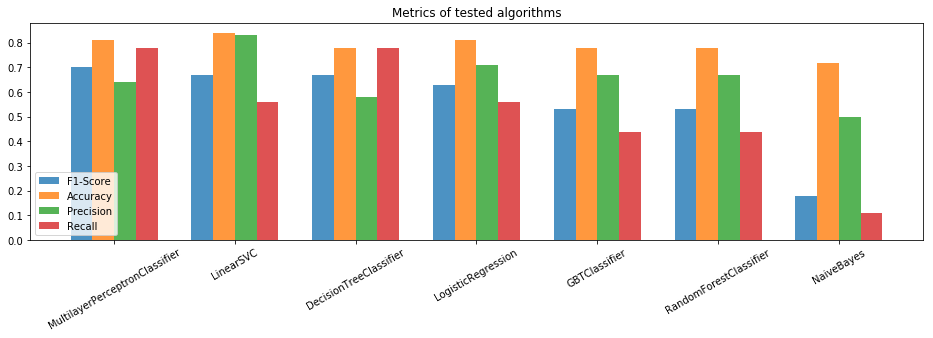

In [21]:
# sort for best model (F1-Score)
best_models_f1 = best_models.sort_values(axis=1, by=["F1-Score", "Accuracy"], ascending=False)
d(best_models_f1)

# plot metric summary
metrics = ["F1-Score", "Accuracy", "Precision", "Recall"]
width = 0.18
x = np.arange(len(best_models_f1.columns))
plt.figure(figsize=(16, 4))
i = -1.5
for metric in metrics:
    plt.bar(x + (width * i), best_models_f1.loc[metric], width=width, alpha=0.8);
    i += 1
plt.legend(metrics, loc=3)
plt.xticks(x, best_models_f1.columns, rotation=30)
plt.title("Metrics of tested algorithms");   

> For the given small dataset and boundary conditions, the __Multilayer Perceptron__ comes out as the winner, benchmarked by F1-Score. The model reached a F1-Score of 0.7 and an accuracy of 0.81.

> The plot demonstrates well, that for this small, unbalanced dataset accuracy it not well suited for evaluation. While accuracy stays on the same level for all tested algorithms, the recall drops significantly.  
This is why overall the F1-Score, considering precision and recall, works well here, pointing out the most balanced algorithm for this usecase.

### Save best model
The best model is saved, so it may be used later on, for example in a web app.

In [22]:
cv_model_mlp.bestModel.stages[-1].write().overwrite().save("best_model")

### Learnings and possible improvements

+ Since the small dataset used in this notebook is just an extract of the bigger dataset, the interaction log for some users is cut off at the beginning or the end (not showing information from registration to cancellation) resulting in biased results when evaluating only the second half of a users membership for example. Also for some users the remaining data is not only biased, but very sparse, making it hard to extract some useful information.
+ Since the dataset contains few entries, this may not be enough for some models like neural networks to train properly or overfit on the data.
+ The data is very biased, considering churn. Only 52 of 225 users churned, which can be a problem for model training and is a possibility for future improvements.  
One point for improvement would be to augment the dataset to make it more balanced. This can be done by getting more data of churning users, dropping data of non churning users or by duplication of data of churning users. Getting more data might be expensive in general, dropping data of an already small dataset not the best choice. So maybe creating some duplicates to learn on might be worth a try.
+ Regarding features, those considering time and activity, like membership duration and active days, stood out as important for modeling.
+ The tested model, especially the best model found, could be optimized further with a more thorough grid search. However, considering the small dataset, the risk to overfit the model probably exists despite cross validation efforts.  
So first of all a bigger dataset should be chosen to optimize the churn prediction.